**Data source: [Monthly Airline Passenger Numbers (in thousands) 1949-1960](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html)**

In [1]:
!python -m wget "https://drive.google.com/uc?export=download&id=1h9iCHXw78jx7IsDPBKPomhA4GZCBpejp" -o AirPassengers.csv

Traceback (most recent call last):
  File "C:\Users\malir\anaconda3\lib\urllib\request.py", line 1346, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "C:\Users\malir\anaconda3\lib\http\client.py", line 1285, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "C:\Users\malir\anaconda3\lib\http\client.py", line 1331, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "C:\Users\malir\anaconda3\lib\http\client.py", line 1280, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "C:\Users\malir\anaconda3\lib\http\client.py", line 1040, in _send_output
    self.send(msg)
  File "C:\Users\malir\anaconda3\lib\http\client.py", line 980, in send
    self.connect()
  File "C:\Users\malir\anaconda3\lib\http\client.py", line 1447, in connect
    super().connect()
  File "C:\Users\malir\anaconda3\lib\http\client.py", line 946, in connect
    self.sock = self._create_

In [2]:
import pandas as pd

df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


**It is worth mentioning that `.describe()` was designed for i.i.d. data and not timeseries, so many times visualization helps here much more.**

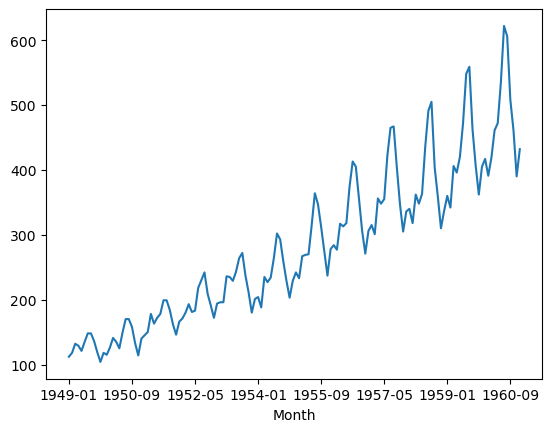

In [4]:
plot = df.set_index("Month")["#Passengers"].plot();

- Trending movement
- Recurring, periodic patterns
    - Can we guess what the period represents?
- And some added variance (noise??)

**Stationary or not ? Using Dickey-Fuller test**

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
result = adfuller(df['#Passengers'].values)
print(f"p-value : how sure it is that the series has a trend : {result[1]:.5f}")
print("Should be under 0.05 to assume stationarity :", result[1] < 0.05 )

p-value : how sure it is that the series has a trend : 0.99188
Should be under 0.05 to assume stationarity : False


#### Visual illustration for trend

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
reindexed_df = df.copy()
reindexed_df.Month = reindexed_df.Month.astype('datetime64[ns]')
reindexed_df = reindexed_df.set_index('Month')

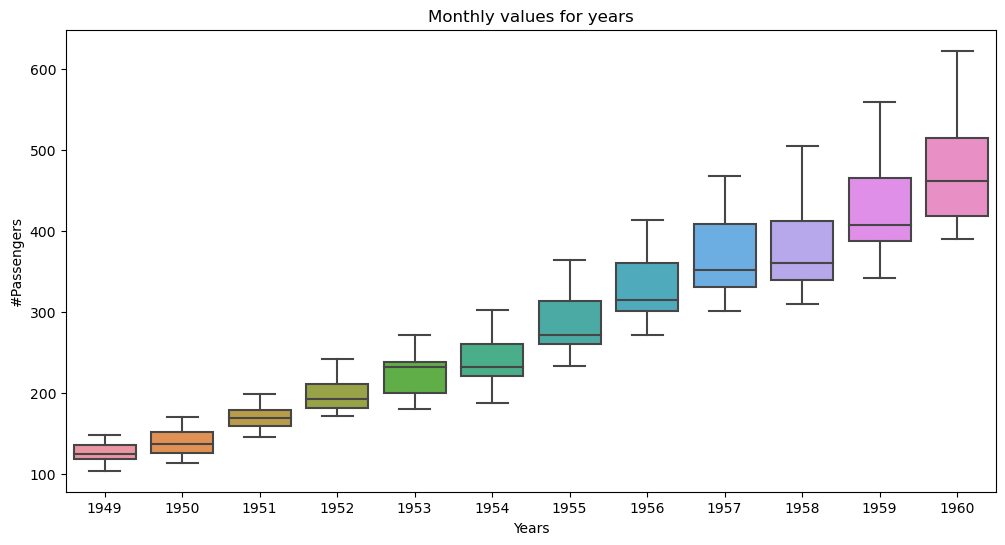

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=reindexed_df.index.year, y=reindexed_df['#Passengers'],ax=ax)
plt.title("Monthly values for years")
plt.xlabel("Years")
plt.show()

#### Periodicity (Seasonality)

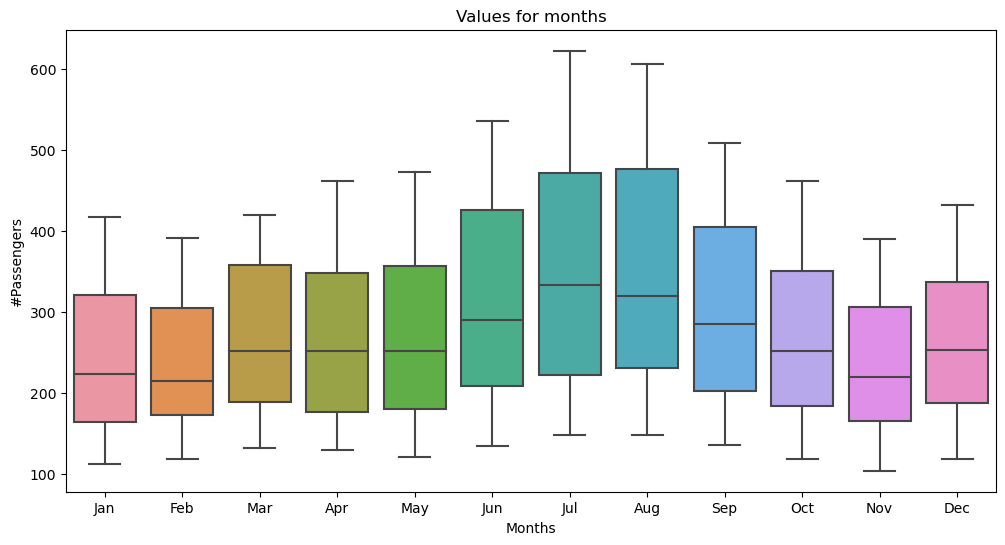

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=reindexed_df.index.strftime("%b"), y=reindexed_df['#Passengers'],ax=ax)
plt.title("Values for months")
plt.xlabel("Months")
plt.show()

#### Decomposition

A time series using an additive model can be thought of as

${\displaystyle y_{t}=T_{t}+S_{t}+I_{t},}$

whereas a multiplicative model would be

${\displaystyle y_{t}=T_{t}\times S_{t}\times I_{t}.\,}$

Where
$T_{t}$ = the **trend component** , $S_{t}$ = the **seasonal component**, $I_t$ = the **irregular component (or "noise")**

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

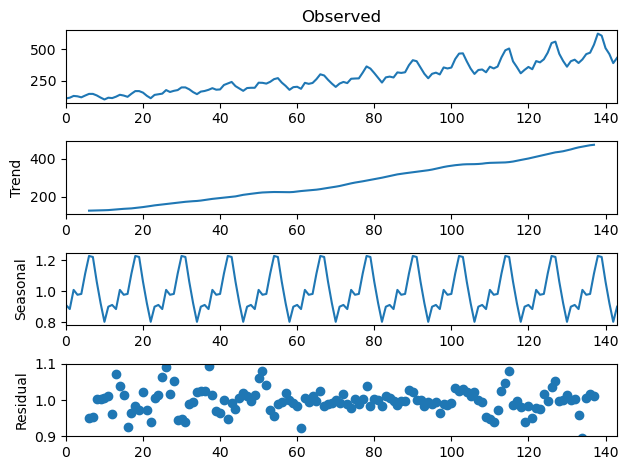

In [19]:
analysis = seasonal_decompose(df["#Passengers"].values, model="multiplicative", period=12)
pd.set_option('display.float_format', '{:.2f}'.format)
analysis.plot()
plt.ylim(0.9, 1.1)
plt.show()

#### What normalizations and transformations can we use?

Trend => One easy and frequently utilized approach to "detrending" the time series is taking its **first difference**.

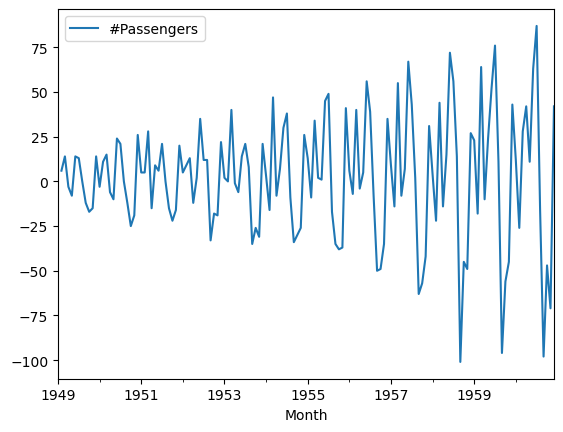

In [20]:
reindexed_df.diff(1).plot()
plt.show()

Seasnolaity => If we take a bigger step, it is also possible to counteract the seasonality effects. The good question is, how we know the proper period for it. None the less, diff can be a way here, too - albeit pretty a crude one.

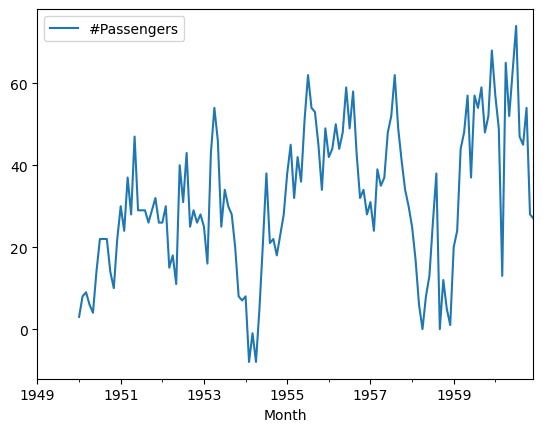

In [21]:
reindexed_df.diff(12).plot()
plt.show()

#### Multiplicative Effects

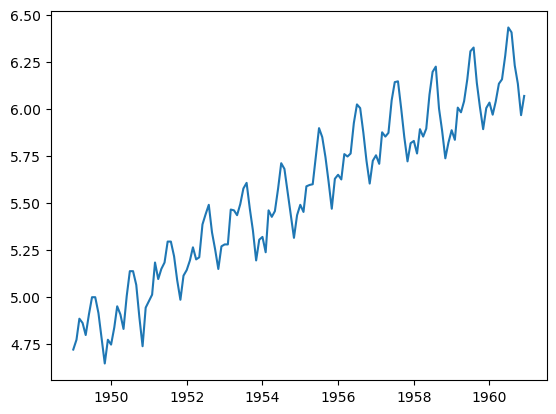

In [22]:
import numpy as np

plt.plot( reindexed_df.index.values, np.log(reindexed_df["#Passengers"]) )
plt.show()

#### What remains ? 

This is absolutely not best practice, but we can see what remains if we chain together the transformations.

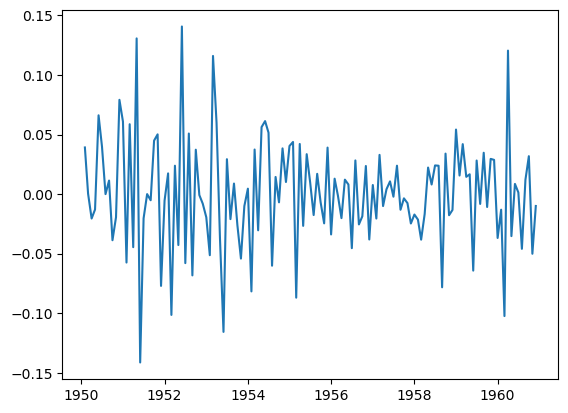

In [23]:
logs = pd.Series(np.log(reindexed_df["#Passengers"])).diff(1).diff(12)
plt.plot(reindexed_df.index.values, logs)
plt.show()

#### ACF & PACF

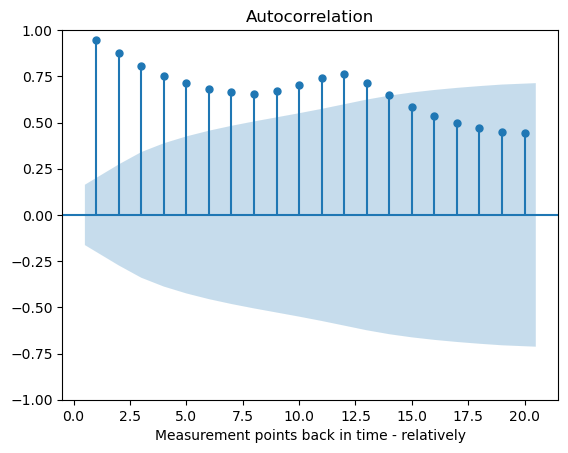

C:\Users\malir\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


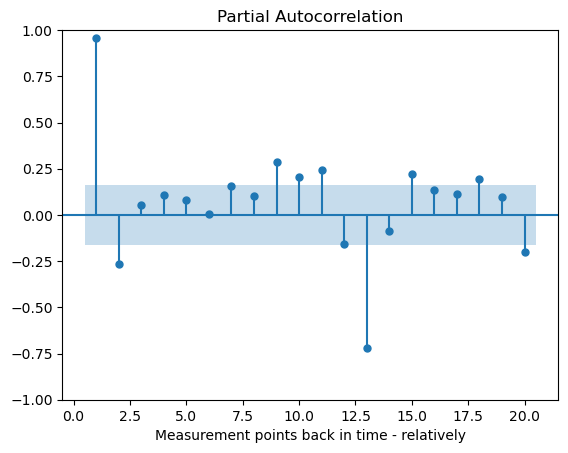

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.close()
plot_acf(df['#Passengers'].values, lags=20, zero=False)
plt.xlabel('Measurement points back in time - relatively')
plt.show()

plot_pacf(df['#Passengers'].values, lags=20, zero=False)
plt.xlabel('Measurement points back in time - relatively')
plt.show()

## Modeling Demonstration
#### Linear Regression: Index as Input

<AxesSubplot:>

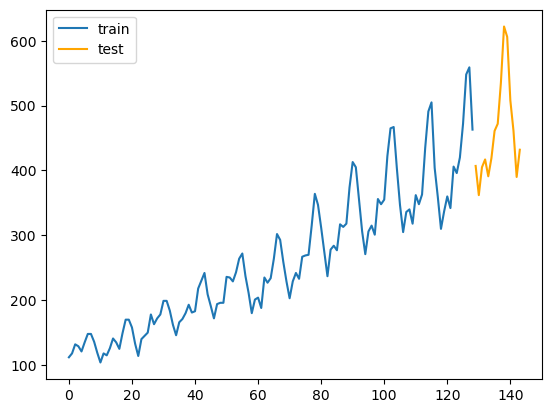

In [30]:
from sklearn.model_selection import train_test_split

# Remember always turn the suffle off to preserve the temporal patterns
train_data, test_data = train_test_split(df, test_size=0.1, shuffle = False)

ax = train_data.rename({'#Passengers':'train'},axis=1).plot()
test_data.rename({'#Passengers':'test'},axis=1).plot(ax=ax, c='orange')

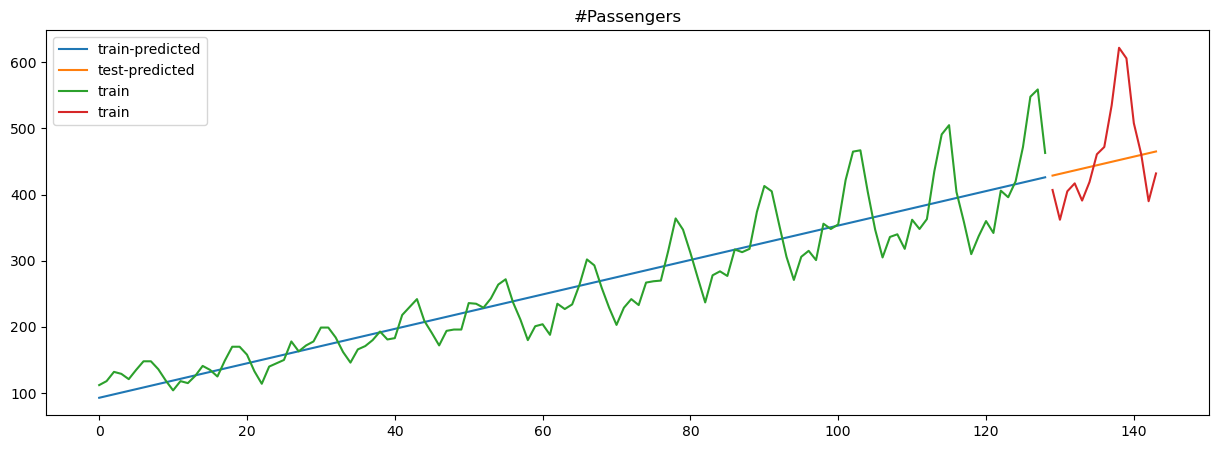

In [45]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(train_data.index.astype('int64').values.reshape(-1,1),train_data['#Passengers'].values)

train_fit = lin_model.predict(train_data.index.astype('int64').values.reshape(-1,1))
train_fit = pd.Series(train_fit)
train_fit.index = train_data.index

prediction = lin_model.predict(test_data.index.astype('int64').values.reshape(-1,1))
prediction = pd.Series(prediction)
prediction.index = test_data.index

plt.figure(figsize=(15,5))

plt.plot(train_fit, label='train-predicted')
plt.plot(prediction, label='test-predicted')

plt.plot(train_data['#Passengers'], label='train')
plt.plot(test_data['#Passengers'], label='train')

plt.title("#Passengers")
plt.legend()

plt.show()

#### Linear Regression: Previous Values as Input
we add previous month's values based on what seemed important in the PACF plot...

In [41]:
df2 = df.copy()

for i in [1,2,9,12]:
    df2[f'prev{i}th_month'] = df2['#Passengers'].shift(i).bfill()

train_data, test_data = train_test_split(df2, test_size=0.1, shuffle=False)

In [42]:
xcols = [c for c in df2.columns if c.startswith("prev")]
xcols

['prev1th_month', 'prev2th_month', 'prev9th_month', 'prev12th_month']

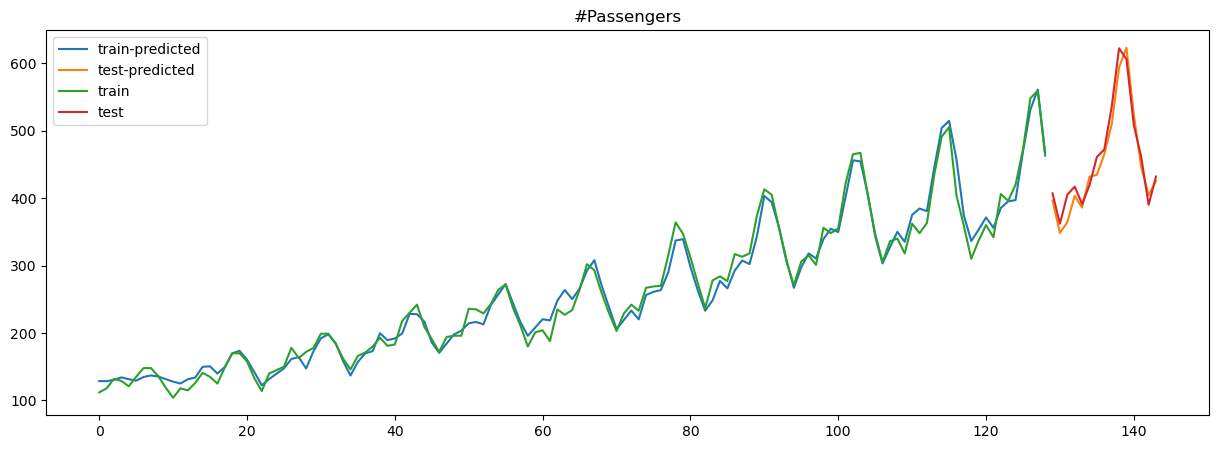

In [44]:
lin_model2 = LinearRegression()
lin_model2.fit(train_data[xcols],train_data["#Passengers"])

train_fit2 = lin_model2.predict(train_data[xcols])
train_fit2 = pd.Series(train_fit2)
train_fit2.index = train_data.index

prediction2 = lin_model2.predict(test_data[xcols])
prediction2 = pd.Series(prediction2)
prediction2.index = test_data.index

plt.figure(figsize=(15,5))

plt.plot(train_fit2, label="train-predicted")
plt.plot(prediction2, label="test-predicted")

plt.plot(train_data["#Passengers"], label="train")
plt.plot(test_data["#Passengers"], label="test")

plt.title("#Passengers")
plt.legend()

plt.show()

#### Exponential Smoothing

In [46]:
from statsmodels.tsa.api import ExponentialSmoothing

predicted=463.000001, expected=407.000000
predicted=407.000001, expected=362.000000
predicted=362.000001, expected=405.000000
predicted=404.999999, expected=417.000000
predicted=417.000000, expected=391.000000
predicted=391.000000, expected=419.000000
predicted=419.000000, expected=461.000000
predicted=460.999999, expected=472.000000
predicted=472.000000, expected=535.000000
predicted=534.999999, expected=622.000000
predicted=621.999999, expected=606.000000
predicted=606.000000, expected=508.000000
predicted=508.000001, expected=461.000000
predicted=461.000001, expected=390.000000
predicted=390.000001, expected=432.000000
Mean abs error: 45.80000024636153
Explained variance: 0.5196648354352387


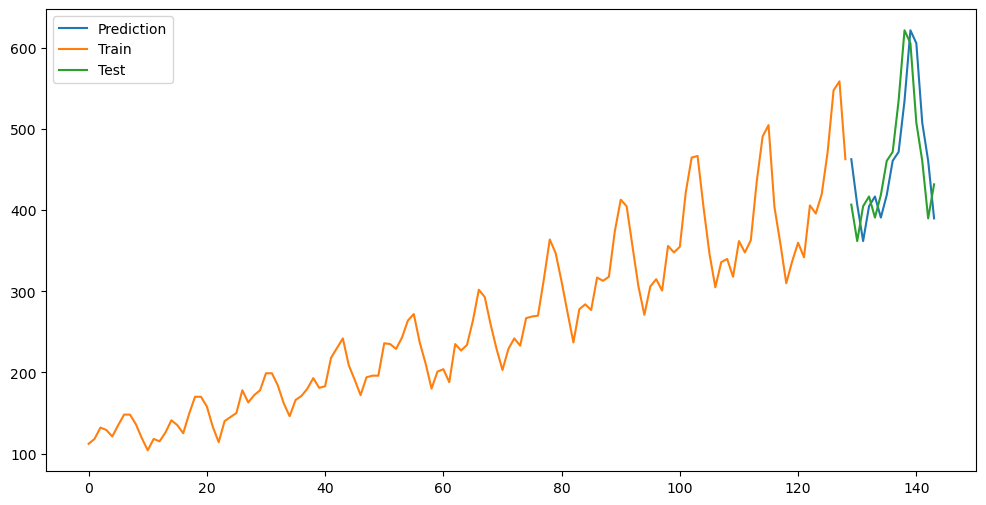

In [53]:
from sklearn.metrics import mean_absolute_error, explained_variance_score

history = [x for x in (train_data["#Passengers"].values.astype('float'))]
predictions = list()

for t in range(len(list(test_data["#Passengers"].values.astype("float")))):
    
    model = ExponentialSmoothing(history,use_boxcox=True)
    model_fit = model.fit()
    
    # Predicting one step ahead
    output = model_fit.forecast(1)
    
    # Collecting predictions
    yhat = output[0]
    predictions.append(yhat)
    
    # Doing one step in time
    obs = list(test_data["#Passengers"].values.astype("float"))[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
print("Mean abs error:",mean_absolute_error(test_data["#Passengers"].values,predictions))
print("Explained variance:",explained_variance_score(test_data["#Passengers"].values,predictions))

predictions = pd.Series(predictions)
predictions.index = test_data.index

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(predictions, label="Prediction")

plt.plot(train_data["#Passengers"], label="Train")

plt.plot(test_data["#Passengers"], label="Test")
plt.legend()
plt.show()

In [54]:
model_fit.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 6.5638985882995735,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': True,
 'lamda': 0.1329659966246411,
 'remove_bias': False}

In [55]:
model_fit.fcastvalues

array([390.])

Effect of smoothing level parameter

In [60]:
## our initial "history" (train data) is our train data
history = list(train_data["#Passengers"].values.astype("float"))

## a dictionary where we will collect test set predictions for each smoothing level (alpha)
predictions_dict = dict()
mu_dict = dict()

for alpha in [0, 0.2, 0.6, 1]:
  ## the predictions list (for the test set) using a given alpha
  predictions = list()

  ## for each time point in the test data
  for t in range(len(test_data)):
    ## instantiate a new model
    model = ExponentialSmoothing(history, use_boxcox=True)

    ## fit the model on the
    ## note: Box Cox transforms non-normal variables into a normal shape
    model_fit = model.fit(smoothing_level=alpha)

    ## prediction for next time step
    output = model_fit.forecast(1)
    yhat = output[0]  ## just one forecast, but we still get an array, so get just the forecast (hence index 0)
    predictions.append(output)

    ## assume one time step passes, append true observation to history
    obs = list(test_data["#Passengers"].values.astype("float"))[t]
    history.append(obs)

  ## all the predictions made using this alpha
  predictions_dict.setdefault(alpha, predictions)


alpha = 0: mean abs error: 210.12153974784727
alpha = 0: explained variance: 0.05801934037048739

alpha = 0.2: mean abs error: 59.78734368357895
alpha = 0.2: explained variance: -0.007568172748484869

alpha = 0.6: mean abs error: 49.19945740241447
alpha = 0.6: explained variance: 0.37120310584640526

alpha = 1: mean abs error: 43.73333333333335
alpha = 1: explained variance: 0.548439293307494


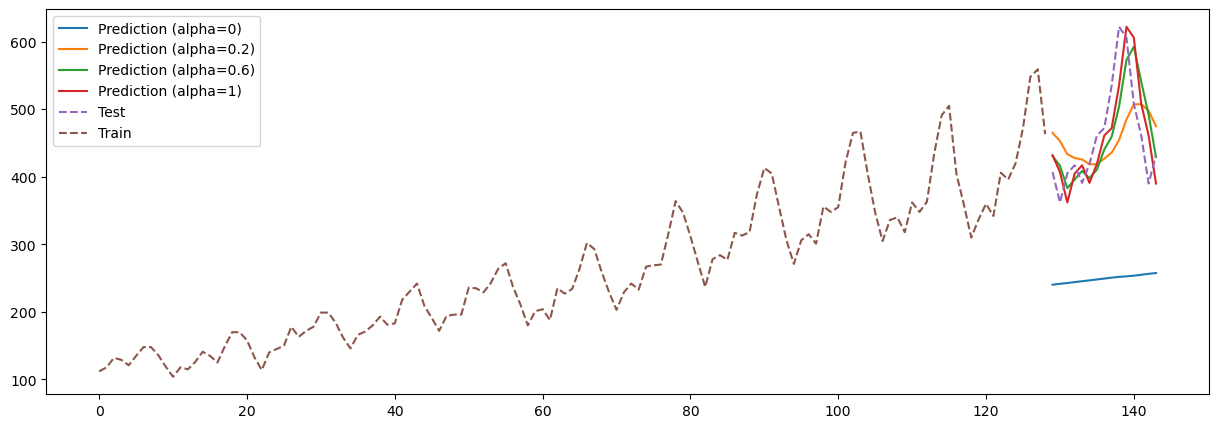

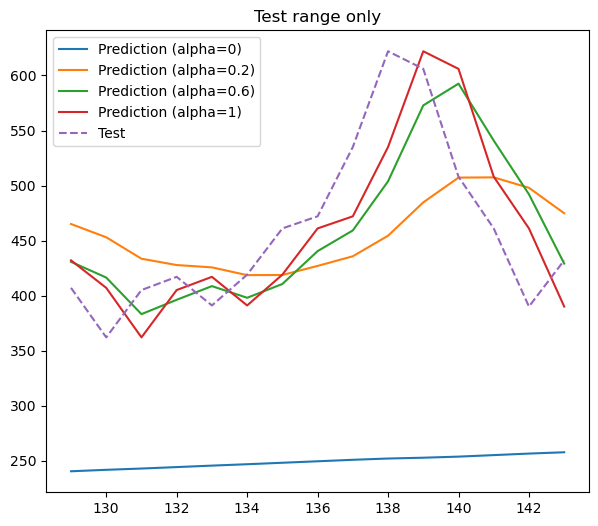

In [71]:
fig, ax = plt.subplots(figsize=(15,5))

for alpha in predictions_dict.keys():
    predictions = predictions_dict[alpha]
    
    erros = np.array(test_data['#Passengers'].values.astype('float')) - np.array(predictions)
    
    print()
    print(f"alpha = {alpha}: mean abs error:",mean_absolute_error(test_data["#Passengers"].values,predictions))
    print(f"alpha = {alpha}: explained variance:",explained_variance_score(test_data["#Passengers"].values,predictions))

    predictions = pd.Series(predictions)
    predictions.index = test_data.index

    plt.plot(predictions, label=f"Prediction (alpha={alpha})")


plt.plot(test_data['#Passengers'],label='Test',linestyle='--')
plt.plot(train_data['#Passengers'],label='Train',linestyle='--')

plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(7,6))

for alpha in predictions_dict.keys():
    predictions = predictions_dict[alpha]
    
    erros = np.array(test_data['#Passengers'].values.astype('float')) - np.array(predictions)

    predictions = pd.Series(predictions)
    predictions.index = test_data.index

    plt.plot(predictions, label=f"Prediction (alpha={alpha})")

plt.plot(test_data["#Passengers"], label="Test", linestyle="--")
plt.legend()
plt.title("Test range only")
plt.show()

#### ARIMA (Autoregressive Integrated Moving Average)

In [75]:
from statsmodels.tsa.arima.model import ARIMA

history = [x for x in list(train_data['#Passengers'].values.astype('float'))]
predictions = list()

print("Predicting forward with ARIMA:\n")

import warnings
with warnings.catch_warnings():
    ## use with care, but right now we don't want our stdout to be cluttered with warnings
    warnings.simplefilter("ignore")
    
    for t in range(len(list(test_data["#Passengers"].values.astype("float")))):
        # Initialize model
        model = ARIMA(history, order=(12,1,0))

        # Do Scikit-like mode.fit()
        model_fit = model.fit()

        # Forecast one time period ahead
        output = model_fit.forecast()

        # Collect it
        yhat = output[0]
        predictions.append(yhat)

        # Step one further in time
        obs = list(test_data["#Passengers"].values.astype("float"))[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))

Predicting forward with ARIMA:

predicted=417.202723, expected=407.000000
predicted=353.350352, expected=362.000000
predicted=389.952193, expected=405.000000
predicted=420.028840, expected=417.000000
predicted=401.668693, expected=391.000000
predicted=444.090070, expected=419.000000
predicted=409.544365, expected=461.000000
predicted=493.432339, expected=472.000000
predicted=512.427674, expected=535.000000
predicted=606.759373, expected=622.000000
predicted=624.246601, expected=606.000000
predicted=516.632013, expected=508.000000
predicted=446.266612, expected=461.000000
predicted=422.681045, expected=390.000000
predicted=426.208570, expected=432.000000


Error analysis


Mean abs error: 17.564878910172446
Explained variance: 0.9208362042346135


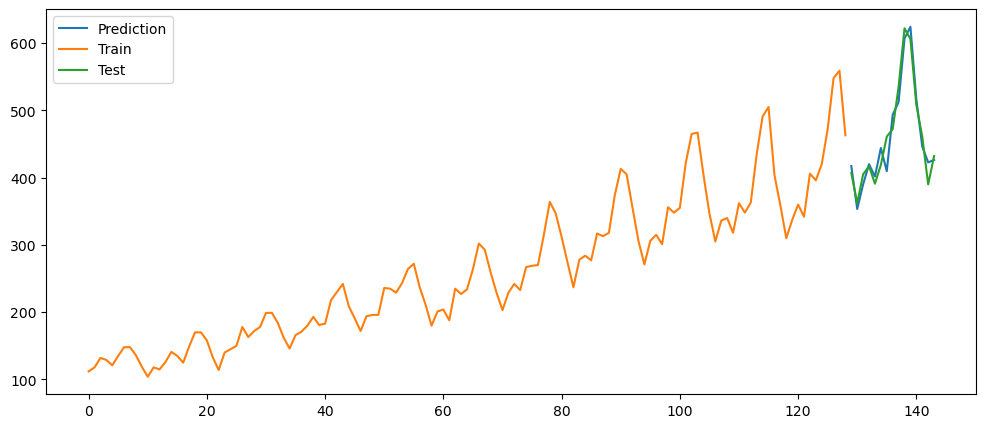

In [76]:
errors = np.array(test_data["#Passengers"].values)-np.array(predictions)

print()
print("Mean abs error:",mean_absolute_error(test_data["#Passengers"].values,predictions))
print("Explained variance:",explained_variance_score(test_data["#Passengers"].values,predictions))

predictions = pd.Series(predictions)
predictions.index =test_data.index

fig, ax = plt.subplots(figsize=(12,5))
plt.plot(predictions, label="Prediction")

plt.plot(train_data["#Passengers"], label="Train")

plt.plot(test_data["#Passengers"], label="Test")
plt.legend()
plt.show()